In [1]:
import numpy as np
import math, random, pandas
import matplotlib.pyplot as plt
from collections import Counter
from qiskit import *
from qiskit.pulse import *
from qiskit.test.mock import *
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel
from qiskit.compiler import assemble
from qiskit.pulse import DriveChannel
from qiskit.pulse import Acquire, AcquireChannel, MemorySlot
from IPython.display import display, Math, HTML
from qiskit.tools.jupyter import *

In [2]:
print("All Fake backends that support Open Pulse: \n")
from qiskit.test import mock as backend_mocks
for fake in dir(backend_mocks.backends):
    if 'Fake' in fake:
        backend = getattr(backend_mocks.backends,fake)()
        if hasattr(backend,'defaults'):
            if backend.configuration().open_pulse:
                print(fake, backend.configuration().n_qubits)

All Fake backends that support Open Pulse: 

FakeAlmaden 20
FakeArmonk 1
FakeAthens 5
FakeBelem 5
FakeBoeblingen 20
FakeCasablanca 7
FakeJohannesburg 20
FakeLima 5
FakeManhattan 65
FakeMontreal 27
FakeMumbai 27
FakeParis 27
FakeQuito 5
FakeSingapore 20
FakeSydney 27
FakeToronto 27
FakeValencia 5


In [13]:
backend = qiskit.test.mock.FakeValencia()
# backend = qiskit.test.mock.FakeAlmaden()
# backend = qiskit.test.mock.FakeArmonk()
backend

<FakeValencia('fake_valencia') from None()>

In [14]:
display(HTML(backend.configuration().hamiltonian['description']))

In [28]:
def fmeasure(bases, sched, backend):
    """
    Measures each qubit of the device (fake) backend according to the dict bases, which has the form
        bases = {1: 'Z', 2: 'X', 5: 'Y', ...}
    where any qubits not explicitly measured in the dict will only receive aqcuire instructions
    The input schedule "sched" will be returned unchanged, except with measurement pulses appended where desired,
    and acquire pulses appended synchronously on ALL qubits
    """
    config = backend.configuration()
    N = config.n_qubits
    assert(len(bases)<=N)

    # CONVERT ABSTRACT CIRCUIT            
    qc = QuantumCircuit(N, N)
    for iq in bases:
        if bases[iq]=='X':
            qc.h(iq)
        if bases[iq]=='Y':
            qc.sdg(iq)
            qc.h(iq)
#         if bases[iq]=='Z':
#             qc.id(iq)
#     for iq in bases:
#         qc.measure(iq,iq)
    for iq in range(N):
        qc.measure(iq,iq)
    qc = transpile(qc, backend)
    measurements = qiskit.schedule(qc, backend)    
#     new_sched = sched.append(measurements)

    sched += measurements << sched.duration
#     new_sched += pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))

#     measure.exclude(channels=[pulse.MeasureChannel(i) for i in range(1, n_qubits)])
    return qc, sched

def n2b(n, b, m):
    """
    n is the integer (base 10) to convert to base b, m is the number of qudits for left padding the output string
    """
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    arr = digits[::-1]
    string = ''.join([str(i) for i in arr])
    assert len(string) <= m, "Representation of integer in desired base exceeds number of qudits"
    return string.zfill(m)

def sample(statevector, k, base, m):
    """
    Given a statevector for m qudits of dimension d=base, generate k samples from the probability distribution
    defined by the statevector over the population of bitsrings that label the vector's indices
    """
    assert abs(np.linalg.norm(statevector) - 1) < 1e-9
    # convert statevector to probability distribution
    probs = np.round(np.abs(statevector)**2 ,2)
    # define all possible outcomes, i.e. for 2 qubits: ["00","01","10","11"]
    population = [n2b(i,base,m) for i in range(len(statevector))]
    zero_str ='0'*m
    population = [zero_str if p==[0] else p for p in population]
    samples = random.choices(population, weights=probs, k=k)
    return samples  

In [59]:
config = backend.configuration() 
config.parametric_pulses=[] #will prevent errors later in the execute call
N = config.n_qubits
defaults = backend.defaults()
dc = pulse.DriveChannel
mc = pulse.MeasureChannel
ac = pulse.AcquireChannel

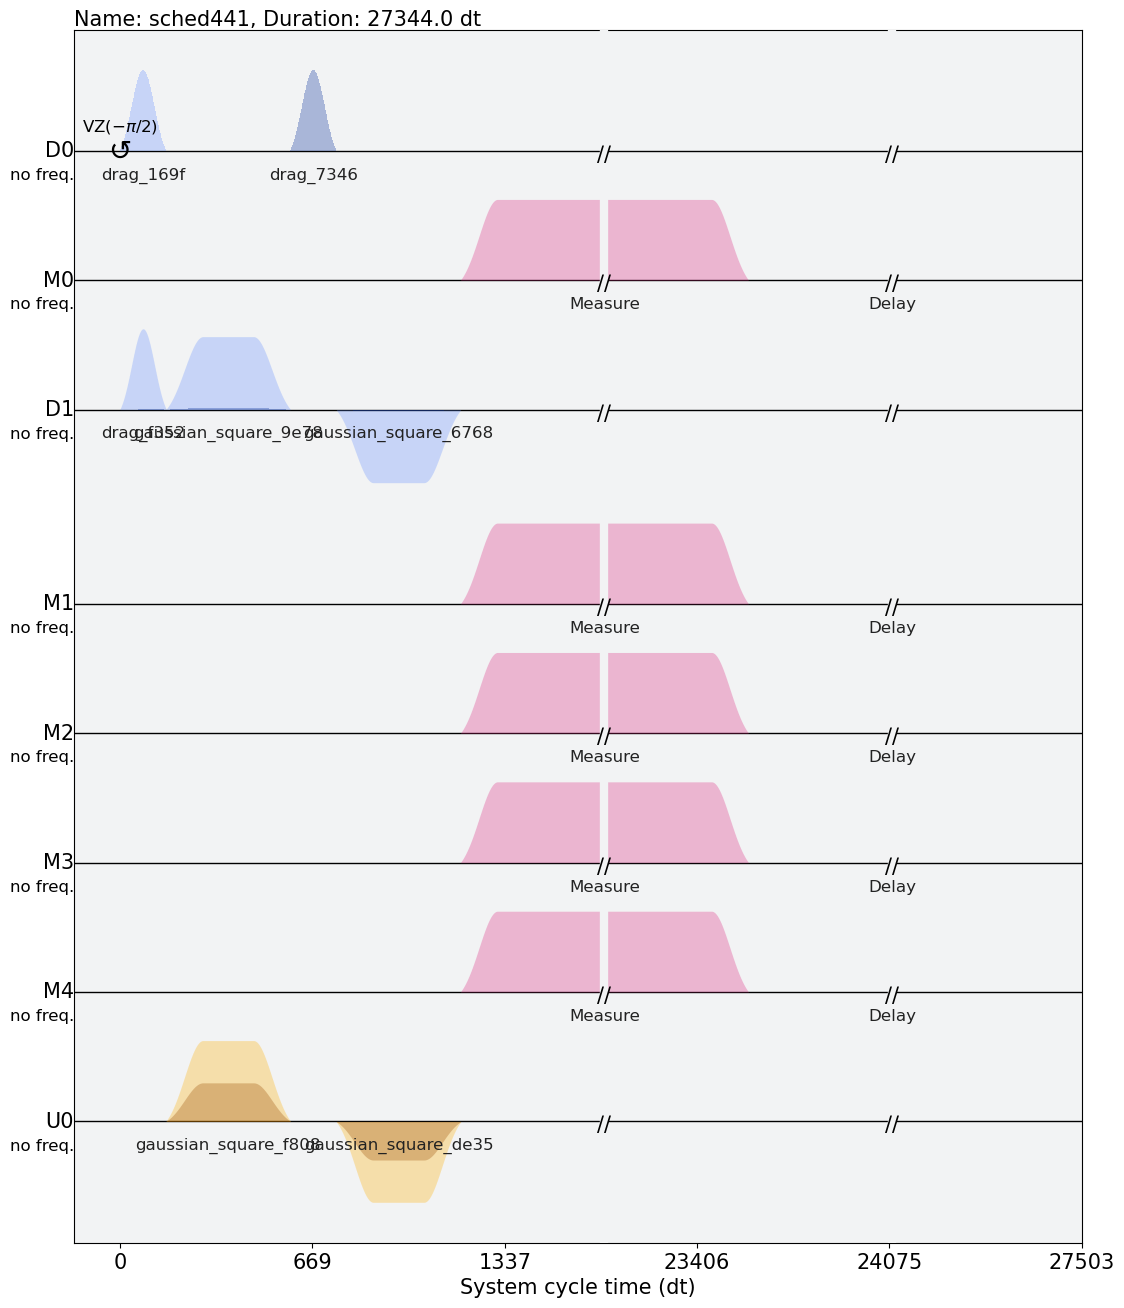

In [84]:
ctrl = 0
targ = 1
with pulse.build(backend) as bad_cnot:
    pulse.cx(ctrl,targ)
    
qc = QuantumCircuit(N,N)
qc.rz(np.pi/2,ctrl)
qc.rx(np.pi/2,targ)
good_cnot = transpile(qc, backend)
good_cnot = qiskit.schedule(good_cnot, backend)    
angle = -np.pi/2
cal = qiskit.transpiler.passes.RZXCalibrationBuilder(backend).get_calibration([angle],[ctrl,targ])
good_cnot += cal << good_cnot.duration
# test_sched = good_cnot
test_sched = bad_cnot

bases = {0:'Z', 1:'Z'}
# bases = {0:'Z', 1:'Z', 2:'Z', 3:'Z', 4:'Z'}
qc, test_sched = fmeasure(bases,test_sched,backend)
test_sched.draw()

In [ ]:
result = execute(test_sched,backend).result()
statevector = result.get_statevector(0)
counts = result.get_counts() #<--- BROKEN

C:\Users\Joey\miniconda3\envs\qiskit\lib\site-packages\qiskit\compiler\assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "
C:\Users\Joey\miniconda3\envs\qiskit\lib\site-packages\qiskit\test\mock\fake_backend.py:127: DeprecationWarning: Passing `system_model` as a positional argument to `PulseSimulator.run` has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Pass `system_model` as a kwarg `system_model=model` instead.
  job = sim.run(qobj, system_model)


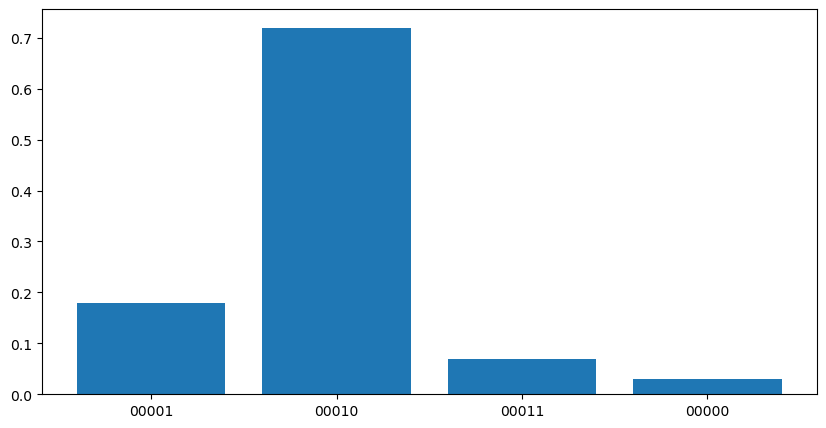

In [76]:
k=100
samples = sample(statevector, k, 3, config.n_qubits)
c = Counter(samples)
plt.figure(figsize=(10,5))
plt.bar(c.keys(), [c/k for c in list(c.values())]) #convert counts to probabilities
plt.show()

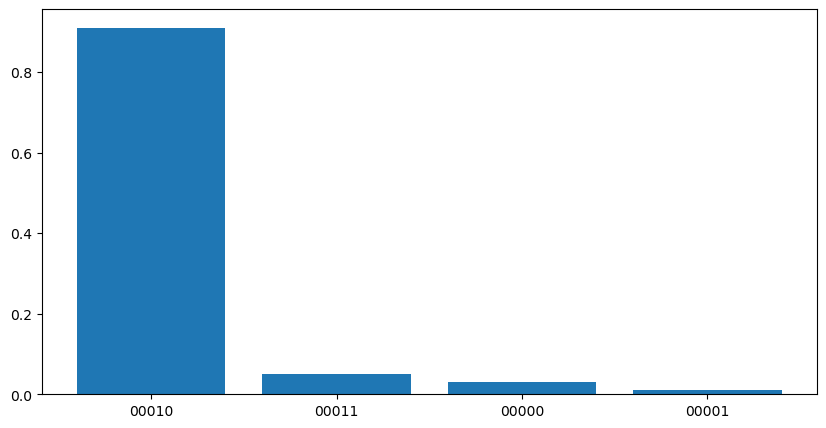

In [83]:
k=100
samples = sample(statevector, k, 3, config.n_qubits)
c = Counter(samples)
plt.figure(figsize=(10,5))
plt.bar(c.keys(), [c/k for c in list(c.values())]) #convert counts to probabilities
plt.show()

In [80]:
np.round(abs(statevector)**2,2)

array([0.02, 0.14, 0.  , 0.79, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.